In [1]:
# borrowed from William's code

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('drive/MyDrive/pests.ai AILAOI')

In [92]:
file_path = 'Data/ISHB_consolidated.csv'

In [93]:
df = pd.read_csv(file_path)

In [94]:
num_of_classes = len(df.INFESTATION_LEVEL.unique())
print(num_of_classes)

4


In [95]:
df = df.fillna({"INFESTATION_LEVEL": "Moderate"})
df = df.fillna({'PRIORITY_FOR_REMOVAL': "Moderate"})
obj_to_int = {"INFESTATION_LEVEL":    {"Severe": 2, "Moderate": 1, "Low": 0}}

In [96]:
df = df.replace(obj_to_int)

In [97]:
X = df.drop(['INFESTATION_LEVEL', 'GlobalID', 'ID', 'Sample Date'], 1)

y = df.INFESTATION_LEVEL

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [98]:
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'CITY' has 16 unique categories
Feature 'HOST_LATIN_NAME' has 11 unique categories
Feature 'HOST_COMMON_NAME' has 17 unique categories
Feature 'REPRODUCTIVE_HOST' has 3 unique categories
Feature 'DIEBACK' has 9 unique categories
Feature 'PRIORITY_FOR_REMOVAL' has 16 unique categories


In [99]:
X['CITY'] = ['South El Monte' if x == 'South El Monte' else 'Other' for x in X['CITY']]

print(X['CITY'].value_counts().sort_values(ascending=False))

South El Monte    352
Other              58
Name: CITY, dtype: int64


In [100]:
todummy_list = ['CITY', 'HOST_LATIN_NAME', 'HOST_COMMON_NAME', 'REPRODUCTIVE_HOST', 'DIEBACK', 'PRIORITY_FOR_REMOVAL']


In [101]:
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [102]:
X = dummy_df(X, todummy_list)
print(X.head(5))

   Data Set  Diameter at Breast Hight_INCHES  HEIGHT_FEET           x  \
0         1                             14.0         30.0 -118.063821   
1         1                             23.0        120.0 -118.063768   
2         1                             12.0         30.0 -118.063848   
3         1                             19.0         55.0 -118.063626   
4         1                             19.0        100.0 -118.063660   

           y  CITY_Other  CITY_South El Monte  HOST_LATIN_NAME_Acer palmatum  \
0  34.046498           0                    1                              0   
1  34.046204           0                    1                              0   
2  34.045881           0                    1                              0   
3  34.046518           0                    1                              0   
4  34.046487           0                    1                              0   

   HOST_LATIN_NAME_Aesculus californica  HOST_LATIN_NAME_Ailanthus altissima  \


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [103]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns = X.columns)

In [104]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

In [105]:
X = add_interactions(X)
print(X.head(5))

   Data Set  Diameter at Breast Hight_INCHES  HEIGHT_FEET           x  \
0       1.0                             14.0         30.0 -118.063821   
1       1.0                             23.0        120.0 -118.063768   
2       1.0                             12.0         30.0 -118.063848   
3       1.0                             19.0         55.0 -118.063626   
4       1.0                             19.0        100.0 -118.063660   

           y  CITY_Other  CITY_South El Monte  HOST_LATIN_NAME_Acer palmatum  \
0  34.046498         0.0                  1.0                            0.0   
1  34.046204         0.0                  1.0                            0.0   
2  34.045881         0.0                  1.0                            0.0   
3  34.046518         0.0                  1.0                            0.0   
4  34.046487         0.0                  1.0                            0.0   

   HOST_LATIN_NAME_Aesculus californica  HOST_LATIN_NAME_Ailanthus altissima  \


In [106]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [80]:
num_of_classes = len(df.INFESTATION_LEVEL.unique())


In [107]:
from xgboost import XGBClassifier

# classifier
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes)

# Fit 
model = xgb.fit(X_train,y_train)

In [108]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing


val = xgb.predict(X_test)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
val_lb = lb.transform(val)

roc_auc_score(y_test_lb, val_lb, average='macro', multi_class='ovo')

0.8296387915435535

In [109]:
preds = model.predict(X_test)

In [110]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, model.predict(X_test))

0.7804878048780488

In [29]:
preds = xgb.predict(X_test)

In [111]:
pd.DataFrame(confusion_matrix(y_test, preds), columns = ['Predicted Low Infestation', 'Predicted Moderate Infestation', 'Predicted Severe Infestation'], index = ['Actual Low Infestation', 'Actual Moderate Infestation', 'Actual Severe Infestation'])

,Predicted Low Infestation,Predicted Moderate Infestation,Predicted Severe Infestation
Actual Low Infestation,22,4,1
Actual Moderate Infestation,6,14,2
Actual Severe Infestation,1,4,28


In [112]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0 : 'Low',
                                        1 : 'Moderate',
                                        2: 'Severe'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

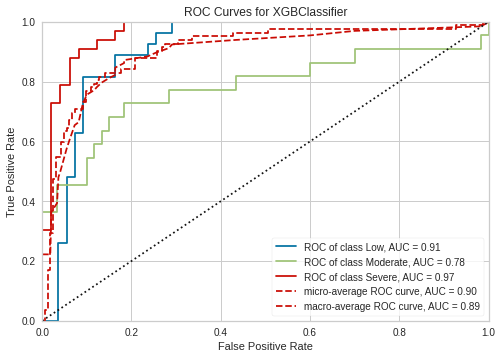

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fba1a542d90>,
       encoder={0: 'Low', 1: 'Moderate', 2: 'Severe'},
       estimator=XGBClassifier(eval_metric='auc', num_class=4,
                               objective='multi:softprob', random_state=42))

In [113]:
plot_ROC_curve(model, X_train, y_train, X_test, y_test)

In [ ]:
file_path = 'Data/Inspected_GSOB_Trees_0.csv'

In [5]:
df = pd.read_csv(file_path)

In [6]:
print(df.shape)

(410, 15)


In [7]:
df.head()

,ID,Data Set,GlobalID,CITY,HOST_LATIN_NAME,HOST_COMMON_NAME,REPRODUCTIVE_HOST,Diameter at Breast Hight_INCHES,HEIGHT_FEET,INFESTATION_LEVEL,DIEBACK,PRIORITY_FOR_REMOVAL,Sample Date,x,y
0,1,1,9f70155b-0869-4558-a797-99d6ce97c4f2,South El Monte,Platanus x hispanica,London plane,Y,14.0,30.0,Moderate,Moderate,Moderate,12/1/20,-118.063821,34.046498
1,2,1,b83e919e-7168-4c78-909e-f81c991415d3,South El Monte,Platanus x hispanica,London plane,Y,23.0,120.0,Heavy,Low,Moderate to high,12/1/20,-118.063768,34.046204
2,3,1,b59163fc-c6d7-4d00-bc26-a13d9a784792,South El Monte,Platanus x hispanica,London plane,Y,12.0,30.0,Low,Low,Low,12/1/20,-118.063848,34.045881
3,4,1,b466c05b-8610-4e9f-b7e1-73da09671d11,South El Monte,Platanus x hispanica,London plane,Y,19.0,55.0,Heavy,Moderate,Moderate to high,12/1/20,-118.063626,34.046518
4,5,1,3d47b5a2-613b-4b1e-a7f1-1102600b32b1,South El Monte,Platanus x hispanica,London plane,Y,19.0,100.0,Severe,Heavy,Moderate to high,12/1/20,-118.063660,34.046487


In [ ]:
num_of_classes = len(df.D_holes.unique())
print(num_of_classes)

4


In [ ]:
print(df['D_holes'].value_counts())

No D holes        5548
Yes, 1-24 MFR     1400
25 + Amplifier     490
Name: D_holes, dtype: int64


In [11]:
df = df.replace(obj_to_int)
df.head()

,ID,Data Set,GlobalID,CITY,HOST_LATIN_NAME,HOST_COMMON_NAME,REPRODUCTIVE_HOST,Diameter at Breast Hight_INCHES,HEIGHT_FEET,INFESTATION_LEVEL,DIEBACK,PRIORITY_FOR_REMOVAL,Sample Date,x,y
0,1,1,9f70155b-0869-4558-a797-99d6ce97c4f2,South El Monte,Platanus x hispanica,London plane,Y,14.0,30.0,1,Moderate,Moderate,12/1/20,-118.063821,34.046498
1,2,1,b83e919e-7168-4c78-909e-f81c991415d3,South El Monte,Platanus x hispanica,London plane,Y,23.0,120.0,2,Low,Moderate to high,12/1/20,-118.063768,34.046204
2,3,1,b59163fc-c6d7-4d00-bc26-a13d9a784792,South El Monte,Platanus x hispanica,London plane,Y,12.0,30.0,0,Low,Low,12/1/20,-118.063848,34.045881
3,4,1,b466c05b-8610-4e9f-b7e1-73da09671d11,South El Monte,Platanus x hispanica,London plane,Y,19.0,55.0,2,Moderate,Moderate to high,12/1/20,-118.063626,34.046518
4,5,1,3d47b5a2-613b-4b1e-a7f1-1102600b32b1,South El Monte,Platanus x hispanica,London plane,Y,19.0,100.0,3,Heavy,Moderate to high,12/1/20,-118.063660,34.046487


In [ ]:
df = df.fillna({"D_holes": "Yes, 1-24 MFR"})

In [ ]:
obj_to_int = {"D_holes":    {"No D holes": 2, "Yes, 1-24 MFR": 1, "25 + Amplifier": 0}}

In [ ]:
df = df.replace(obj_to_int)
df.head()

,OBJECTID,Current Status,Date,Species,Height,Canopy Spread L,Canopy Spread W,Canopy Cover,Staining,Diameter Breast Height,...,created_date,last_edited_user,last_edited_date,OBJECTID_3,GlobalID,Date Treated,Date TO BE Treated,D Holes AFTER Treatment,x,y
0,1,Monitor,1/2/2016 4:00:00 PM,Quer Agrifolia,0,0,0,0,NaN,14,...,3/19/2022 3:32:49 AM,Lady_Terrazas_LearnArcGIS,3/19/2022 3:32:49 AM,1,5de2f1f9-dfc8-4db3-86d7-83be624c1285,NaN,NaN,NaN,-118.417815,34.617676
1,2,Removed Owner,10/17/2017 3:00:00 PM,Quer Agrifolia,0,0,0,0,NaN,12,...,3/19/2022 3:32:49 AM,Lady_Terrazas_LearnArcGIS,3/19/2022 3:32:49 AM,2,784313e1-dade-4b34-a377-51e25a485585,NaN,NaN,NaN,-118.417185,34.617986
2,3,Removed Fire,1/2/2016 4:00:00 PM,Quer Agrifolia,0,0,0,0,NaN,0,...,3/19/2022 3:32:49 AM,Lady_Terrazas_LearnArcGIS,3/19/2022 3:32:49 AM,3,332d5025-8602-473d-a388-4268b9bc7b26,NaN,NaN,NaN,-118.417338,34.618055
3,4,Removed Fire,1/2/2016 4:00:00 PM,Quer Agrifolia,0,0,0,0,NaN,17,...,3/19/2022 3:32:49 AM,Lady_Terrazas_LearnArcGIS,3/19/2022 3:32:49 AM,4,8e6a7e0d-a4bc-4485-86ec-efdd4c523efb,NaN,NaN,NaN,-118.417169,34.618023
4,5,Removed Fire,1/2/2016 4:00:00 PM,Quer Agrifolia,0,0,0,0,NaN,20,...,3/19/2022 3:32:49 AM,Lady_Terrazas_LearnArcGIS,3/19/2022 3:32:49 AM,5,20c48262-5e30-4c5a-b918-437aae8b92cd,NaN,NaN,NaN,-118.417205,34.618024


In [ ]:
print(df['D_holes'].value_counts())

2    5548
1    1675
0     490
Name: D_holes, dtype: int64


In [ ]:
X = df.drop(['OBJECTID', 'Current Status', 'Date', 'Multi DBH?', 'MultiDBH-edit to show 2nd largest stem', 'D_holes', 'Tree Tag Number', 'Previous Comments', 'created_user', 'created_date', 'last_edited_user', 'last_edited_date', 'OBJECTID_3', 'GlobalID', 'Date Treated', 'Date TO BE Treated', 'D Holes AFTER Treatment'], 1)

y = df.D_holes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [ ]:
print(X.head(5))

          Species  Height  Canopy Spread L  Canopy Spread W  Canopy Cover  \
0  Quer Agrifolia       0                0                0             0   
1  Quer Agrifolia       0                0                0             0   
2  Quer Agrifolia       0                0                0             0   
3  Quer Agrifolia       0                0                0             0   
4  Quer Agrifolia       0                0                0             0   

  Staining  Diameter Breast Height  D Holes Original #  POINT_X_1   POINT_Y_1  \
0      NaN                      14                   0  34.617672 -118.417802   
1      NaN                      12                  30  34.617981 -118.417172   
2      NaN                       0                 100  34.618050 -118.417326   
3      NaN                      17                   0  34.618019 -118.417156   
4      NaN                      20                   3  34.618019 -118.417192   

            x          y  
0 -118.417815  34.61767

In [ ]:
print(y.head(5))

0    2
1    0
2    0
3    2
4    1
Name: D_holes, dtype: int64


In [ ]:
for col_name in X.columns:
    if X[col_name].dtypes == 'object':
        unique_cat = len(X[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} unique categories".format(col_name=col_name, unique_cat=unique_cat))

Feature 'Species' has 7 unique categories
Feature 'Staining' has 3 unique categories


In [ ]:
print(X['Staining'].value_counts().sort_values(ascending=False).head(10))
print(X['Species'].value_counts().sort_values(ascending=False).head(10))
#print(X['Current Status'].value_counts().sort_values(ascending=False).head(10))

No     4374
Yes    1689
Name: Staining, dtype: int64
Quer Agrifolia         7649
Quer Chrysolepis         57
Other                     2
Quer Kelloggii            2
Quercus kellogii          1
Quercus engelmannii       1
Quer Kellogi              1
Name: Species, dtype: int64


In [ ]:
X['Species'] = ['Quer Agrifolia' if x == 'Quer Agrifolia' else 'Other' for x in X['Species']]

print(X['Species'].value_counts().sort_values(ascending=False))

Quer Agrifolia    7649
Other               64
Name: Species, dtype: int64


In [ ]:
#X['Current Status'] = ['Non-Infested' if x == 'Non-Infested' else 'Other' for x in X['Current Status']]


In [ ]:
todummy_list = ['Current Status', 'Species', 'Staining']

In [ ]:
todummy_list = ['Species', 'Staining']

In [ ]:
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

In [ ]:
X = dummy_df(X, todummy_list)
print(X.head(5))

   Height  Canopy Spread L  Canopy Spread W  Canopy Cover  \
0       0                0                0             0   
1       0                0                0             0   
2       0                0                0             0   
3       0                0                0             0   
4       0                0                0             0   

   Diameter Breast Height  D Holes Original #  POINT_X_1   POINT_Y_1  \
0                      14                   0  34.617672 -118.417802   
1                      12                  30  34.617981 -118.417172   
2                       0                 100  34.618050 -118.417326   
3                      17                   0  34.618019 -118.417156   
4                      20                   3  34.618019 -118.417192   

            x          y  Species_Other  Species_Quer Agrifolia  Staining_No  \
0 -118.417815  34.617676              0                       1            0   
1 -118.417185  34.617986              0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


In [ ]:
X.isnull().sum().sort_values(ascending = False).head()

POINT_X_1          1131
Height                0
Canopy Spread L       0
Canopy Spread W       0
Canopy Cover          0
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns = X.columns)

In [ ]:
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    
    # Remove interaction terms with all 0 values            
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)
    
    return df

In [ ]:
X = add_interactions(X)
print(X.head(5))

   Height  Canopy Spread L  Canopy Spread W  Canopy Cover  \
0     0.0              0.0              0.0           0.0   
1     0.0              0.0              0.0           0.0   
2     0.0              0.0              0.0           0.0   
3     0.0              0.0              0.0           0.0   
4     0.0              0.0              0.0           0.0   

   Diameter Breast Height  D Holes Original #  POINT_X_1   POINT_Y_1  \
0                    14.0                 0.0  34.617672 -118.417802   
1                    12.0                30.0  34.617981 -118.417172   
2                     0.0               100.0  34.618050 -118.417326   
3                    17.0                 0.0  34.618019 -118.417156   
4                    20.0                 3.0  34.618019 -118.417192   

            x          y  ...  x_Staining_No  x_Staining_Yes  y_Species_Other  \
0 -118.417815  34.617676  ...           -0.0            -0.0              0.0   
1 -118.417185  34.617986  ...         

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

In [ ]:
from xgboost import XGBClassifier

# classifier
xgb = XGBClassifier(booster='gbtree', objective='multi:softprob', random_state=42, eval_metric="auc", num_class=num_of_classes)

# Fit 
model = xgb.fit(X_train,y_train)


In [ ]:
model.predict_proba(X_test)

array([[1.4036498e-03, 1.0490768e-01, 8.9368868e-01],
       [9.9340641e-01, 5.8900448e-03, 7.0355140e-04],
       [6.9501327e-04, 3.1320639e-02, 9.6798438e-01],
       ...,
       [4.1460278e-04, 1.6623627e-02, 9.8296183e-01],
       [5.7420263e-04, 2.3395322e-02, 9.7603047e-01],
       [4.4586643e-04, 1.7790603e-02, 9.8176354e-01]], dtype=float32)

In [ ]:
model.predict(X_test)

array([2, 0, 2, ..., 2, 2, 2])

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing


val = xgb.predict(X_test)

lb = preprocessing.LabelBinarizer()
lb.fit(y_test)

y_test_lb = lb.transform(y_test)
val_lb = lb.transform(val)

roc_auc_score(y_test_lb, val_lb, average='macro', multi_class='ovo')

0.9584961005548581

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, model.predict(X_test))

0.966299416720674

In [ ]:
preds = model.predict(X_test)

In [ ]:
from joblib import dump, load
dump(model, 'model.joblib') 

['model.joblib']

In [ ]:
# md = load('model.joblib')

In [ ]:
# accuracy_score(y_test, md.predict(X_test))

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
pd.DataFrame(confusion_matrix(y_test, preds), columns=['Predicted High Infestation', "Predicted Medium Infestation", 'Predicted No Infestation'], index=['Actual High Infestation', 'Actual Medium Infestation', 'Actual No Infestation'])

,Predicted High Infestation,Predicted Medium Infestation,Predicted No Infestation
Actual High Infestation,95,0,0
Actual Medium Infestation,3,285,42
Actual No Infestation,2,5,1111


In [ ]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model, X_train, y_train, X_test, y_test):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'High Infestation', 
                                        1: 'Medium Infestation', 
                                        2: 'No Infestation'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

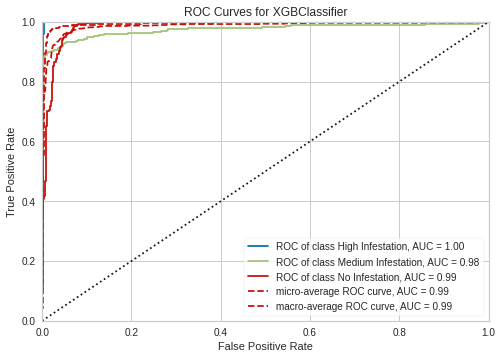

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc05e46f410>,
       encoder={0: 'High Infestation', 1: 'Medium Infestation',
                2: 'No Infestation'},
       estimator=XGBClassifier(eval_metric='auc', num_class=4,
                               objective='multi:softprob', random_state=42))

In [ ]:
plot_ROC_curve(model, X_train, y_train, X_test, y_test)